In [1]:
'''math tool'''
import csv
import numpy as np

'''plot tool'''
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import matplotlib.ticker as ticker

'''image tool'''
import cv2
#import pyrealsense2 as rs
import statistics as sta

In [3]:
raw_pgm_35 = cv2.imread("/home/ncslaber/110-1/211002_allLibrary/2021-10-02-17-29-15/1116_test2_after_preprocess/30-50/1116.pgm")
raw_pgm_57 = cv2.imread("/home/ncslaber/110-1/211002_allLibrary/2021-10-02-17-29-15/1116_test2_after_preprocess/50-70/1116.pgm")
raw_pgm_79 = cv2.imread("/home/ncslaber/110-1/211002_allLibrary/2021-10-02-17-29-15/1116_test2_after_preprocess/70-90/1116.pgm")
# if raw_pgm is None:
#     print("Image is empty!!")
raw_pgm_color_35 = np.zeros(raw_pgm_35.shape,dtype=np.uint8) + 255
raw_pgm_color_57 = np.zeros(raw_pgm_57.shape,dtype=np.uint8) + 255
raw_pgm_color_79 = np.zeros(raw_pgm_79.shape,dtype=np.uint8) + 255
raw_pgm_35 = cv2.cvtColor(raw_pgm_35, cv2.COLOR_RGB2GRAY)
raw_pgm_57 = cv2.cvtColor(raw_pgm_57, cv2.COLOR_RGB2GRAY)
raw_pgm_79 = cv2.cvtColor(raw_pgm_79, cv2.COLOR_RGB2GRAY)
(width, height) = raw_pgm_79.shape # the order is right
print("pgm height is: ",height)

pgm height is:  2048


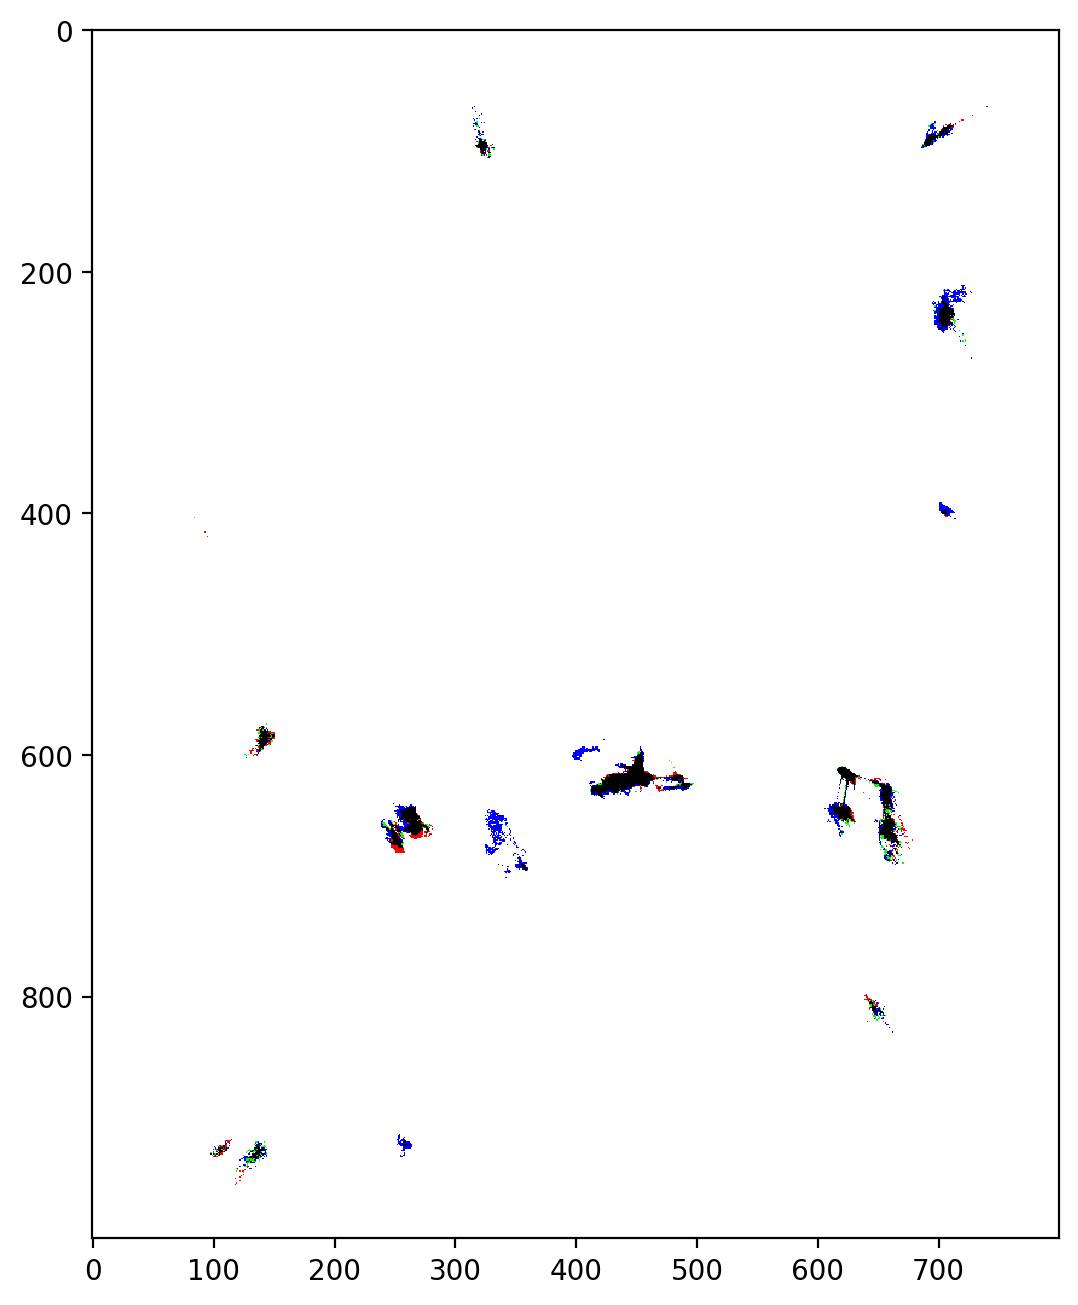

In [4]:
raw_pgm_color_35[raw_pgm_35==0]=(0,0,255)
raw_pgm_color_57[raw_pgm_57==0]=(0,255,0)
raw_pgm_color_79[raw_pgm_79==0]=(255,0,0)
accu_map = cv2.bitwise_and(raw_pgm_color_35, raw_pgm_color_57)
accu_map = cv2.bitwise_and(accu_map, raw_pgm_color_79)
fig3, ax3 = plt.subplots(figsize=(8, 8),dpi=200)
plt.imshow(cv2.cvtColor(accu_map[700:1700,700:1500], cv2.COLOR_BGR2RGB))

### find connected component

In [11]:
def morph_map(raw_pgm_binary):
    kernel = np.ones((3,3), np.uint8)
    raw_pgm_binary = cv2.dilate(raw_pgm_binary, kernel, iterations = 1)
    raw_pgm_binary = cv2.erode(raw_pgm_binary,kernel,iterations = 1)
#     fig = plt.figure(figsize=(10,10))
#     subplot = fig.add_subplot(121)
#     subplot.imshow(cv2.cvtColor(raw_pgm, cv2.COLOR_BGR2RGB))
#     subplot = fig.add_subplot(122)
#     subplot.imshow(cv2.cvtColor(raw_pgm_binary, cv2.COLOR_BGR2RGB))
    plt.imshow(cv2.cvtColor(raw_pgm_binary[700:1700,700:1500], cv2.COLOR_BGR2RGB))
    return raw_pgm_binary

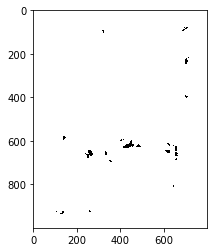

In [19]:
raw_pgm_binary_all = np.zeros(raw_pgm_35.shape,dtype=np.uint8) + 255
mask = np.logical_or(raw_pgm_35==0, raw_pgm_57==0)
mask = np.logical_or(mask, raw_pgm_79==0)
raw_pgm_binary_all[mask]=0
morph_pgm_binary_all = morph_map(raw_pgm_binary_all)

In [96]:
cv2.write('/home/ncslaber/1116',cv2.cvtColor(morph_pgm_binary_all, cv2.COLOR_BGR2RGB))

error: OpenCV(4.2.0) ../modules/imgcodecs/src/loadsave.cpp:661: error: (-2:Unspecified error) could not find a writer for the specified extension in function 'imwrite_'


In [82]:
tmp = np.zeros(raw_pgm_35.shape,dtype=np.uint8) 
tmp[morph_pgm_binary_all==0]=255
num_objects, labels = cv2.connectedComponents(tmp)
print('>>>># of raw objects:',num_objects)
num_objects,labels.shape

>>>># of raw objects: 27


(27, (2048, 2048))

In [ ]:
status = {}

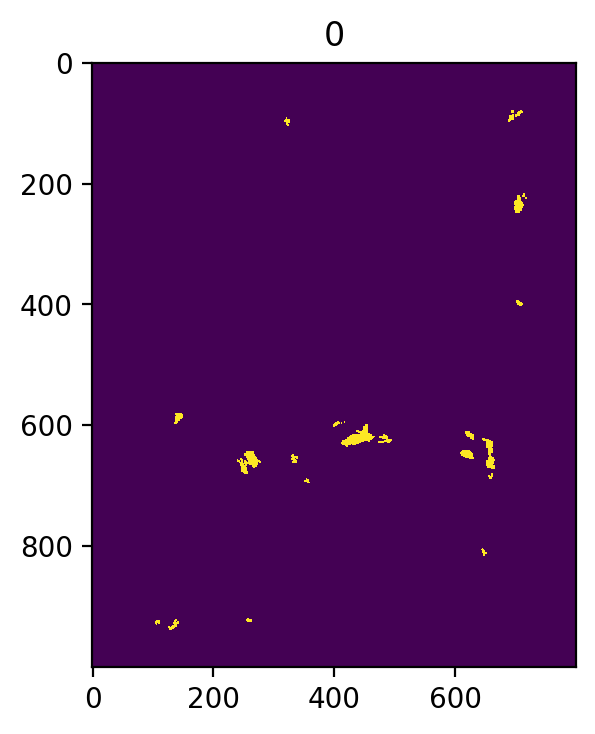

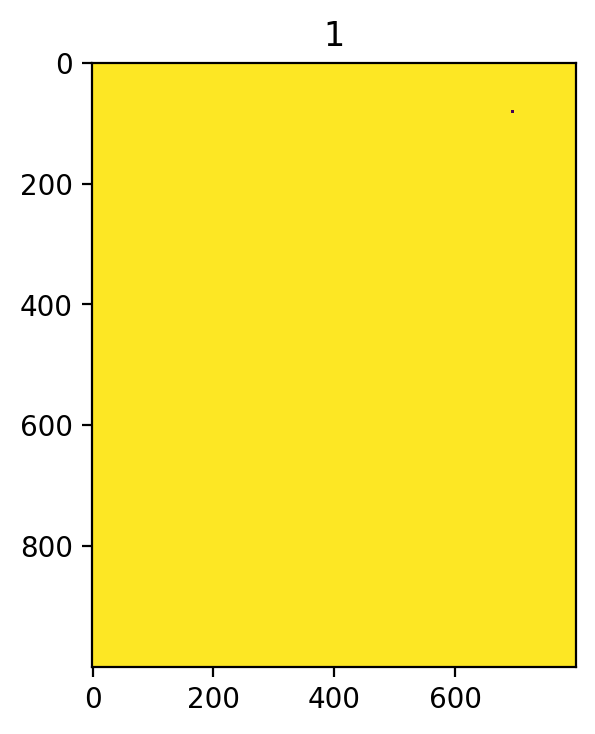

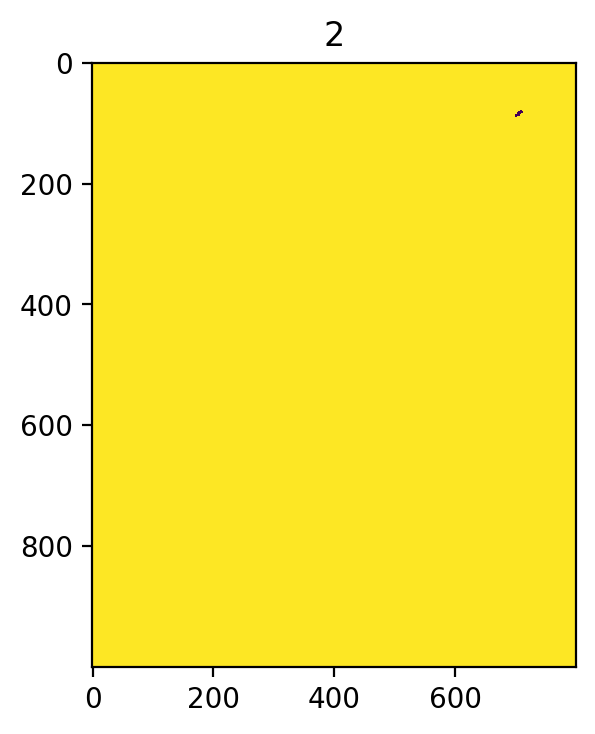

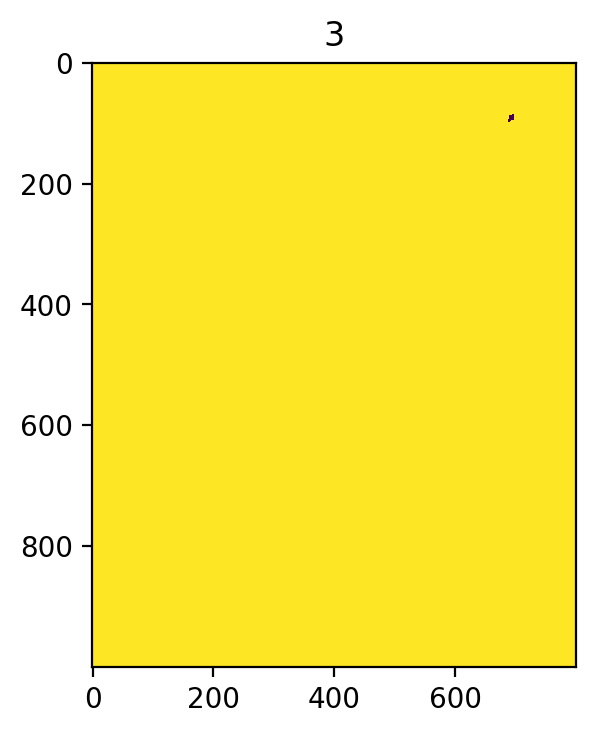

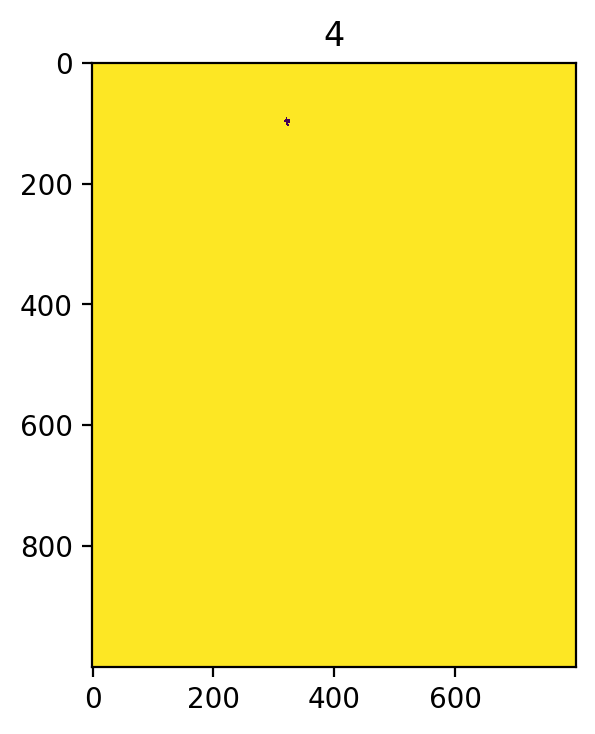

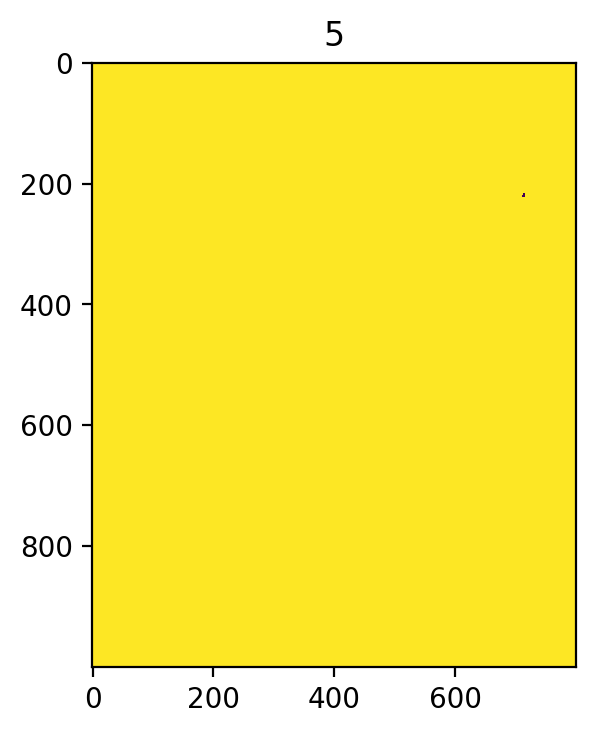

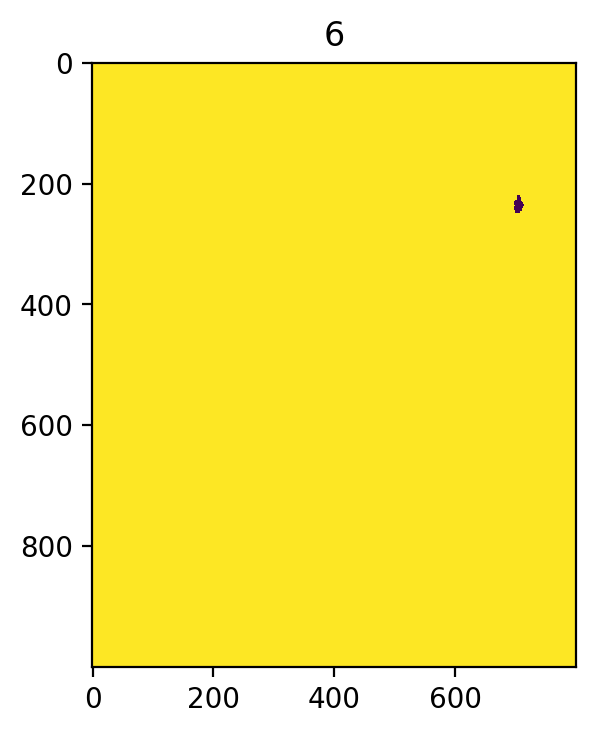

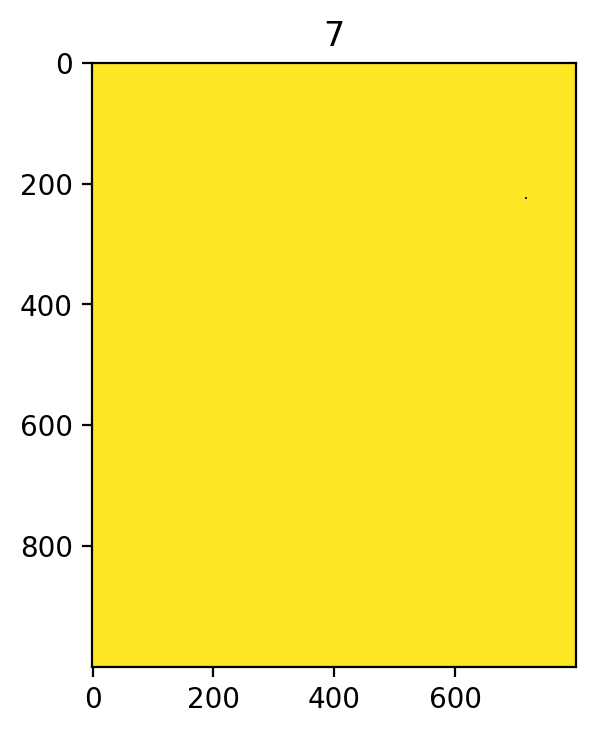

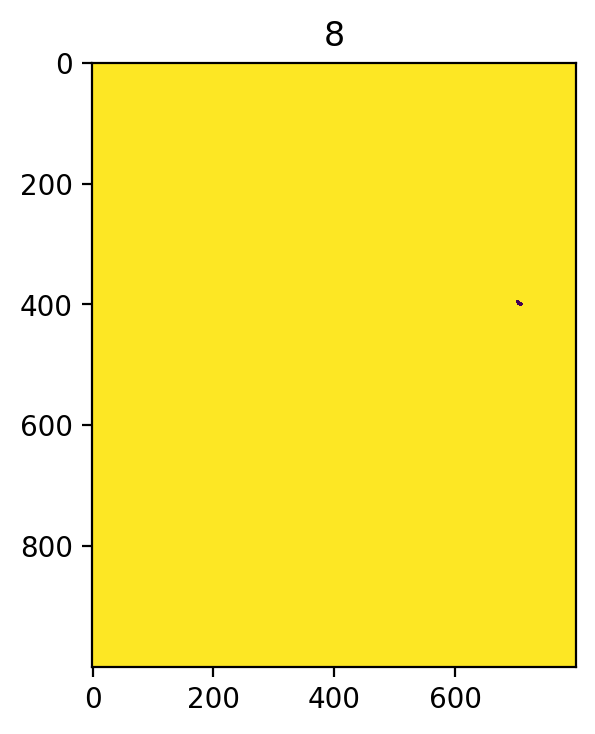

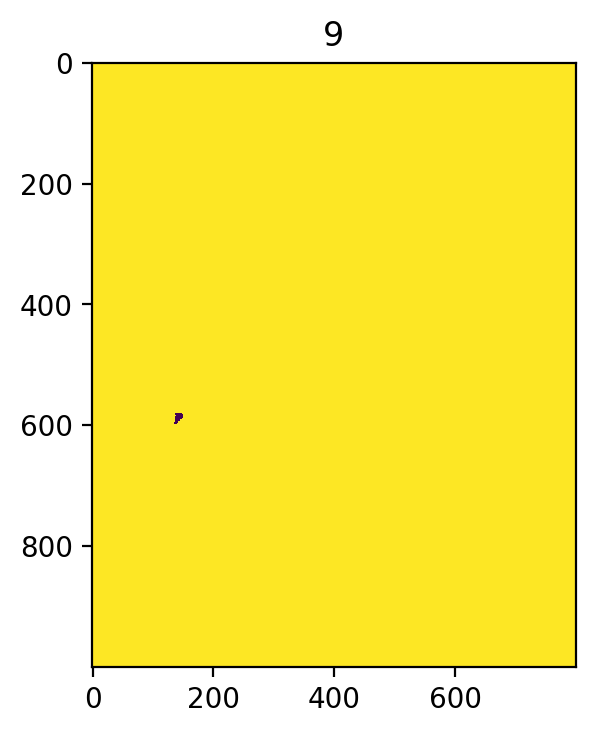

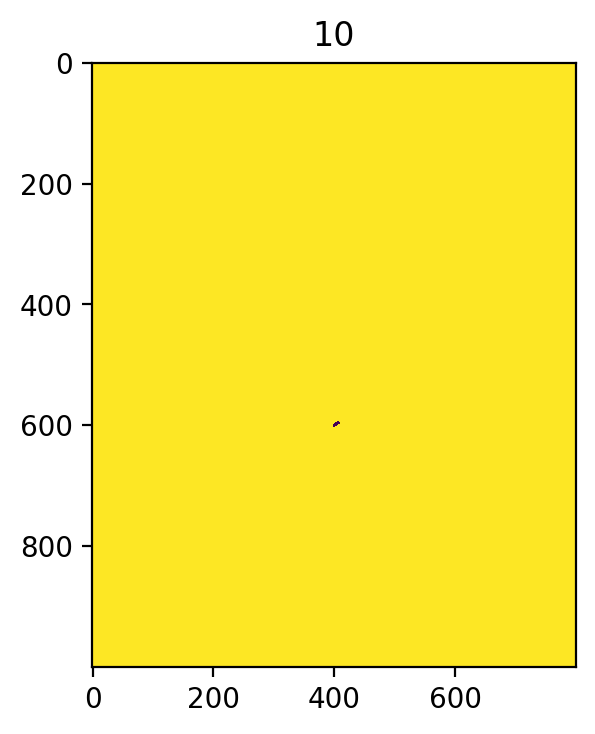

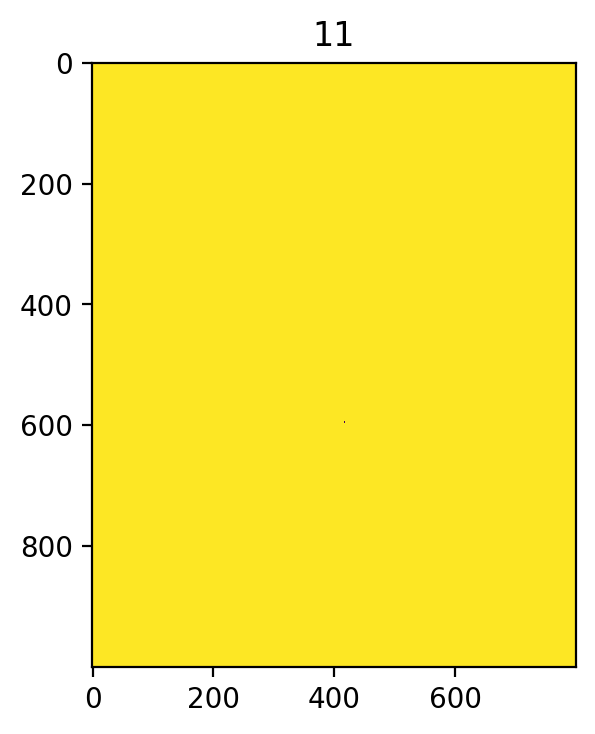

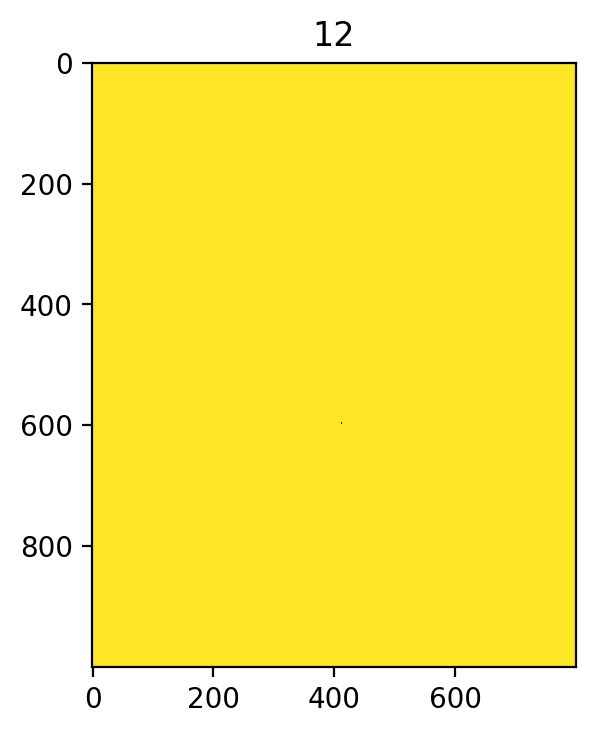

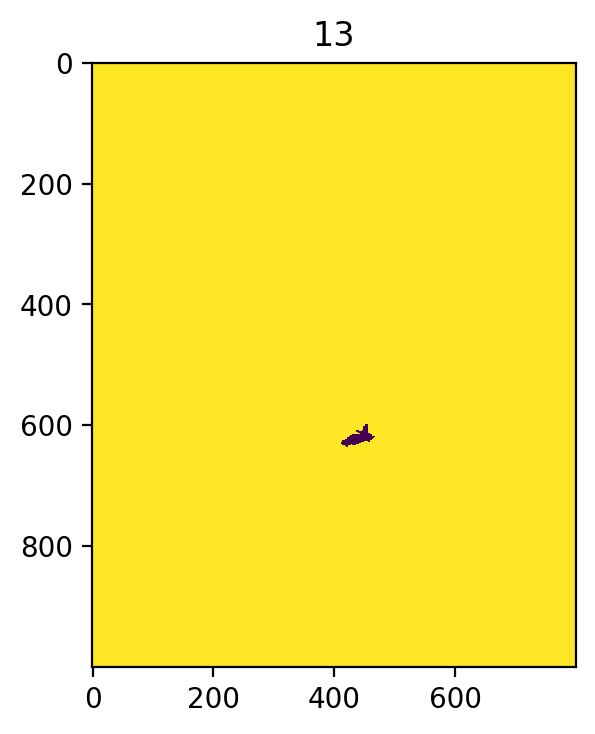

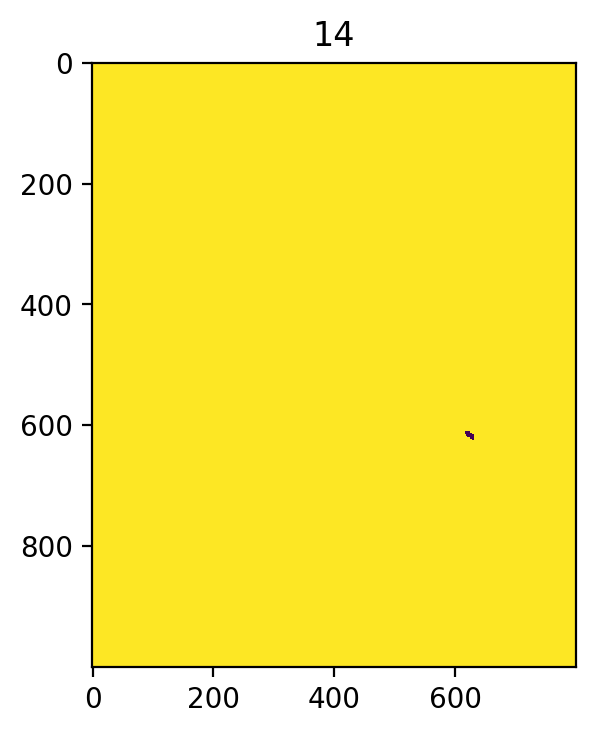

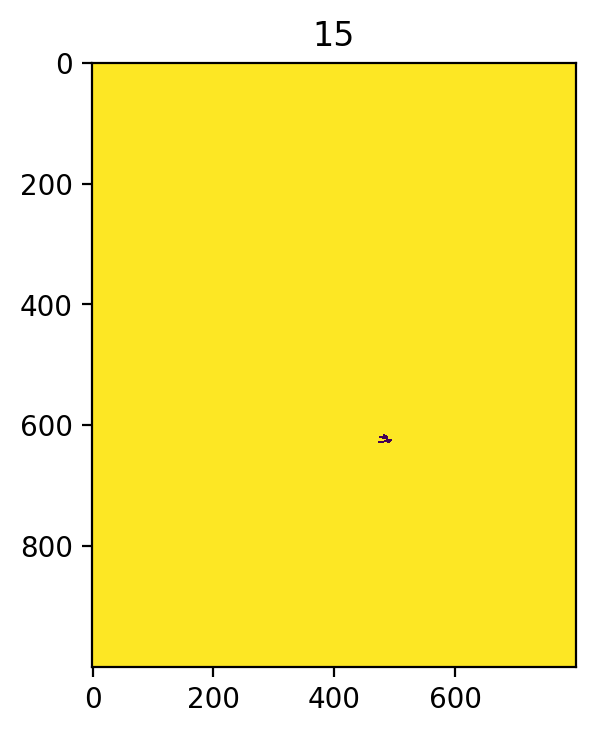

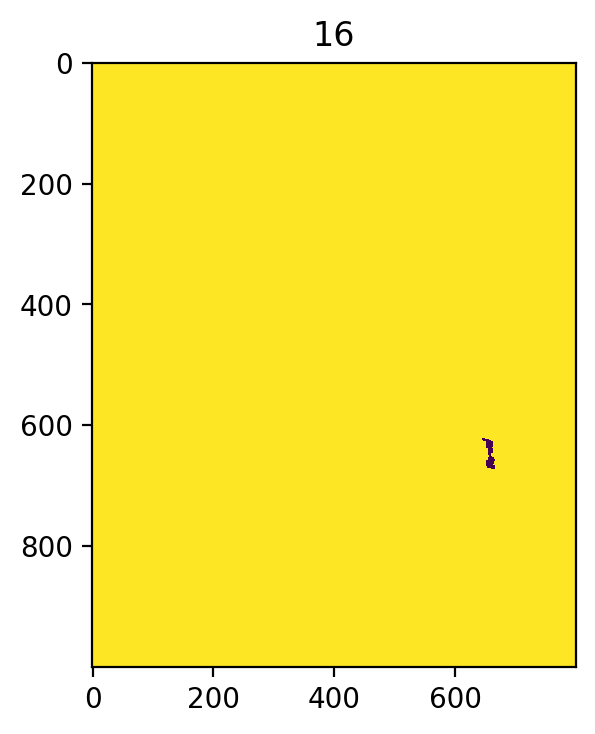

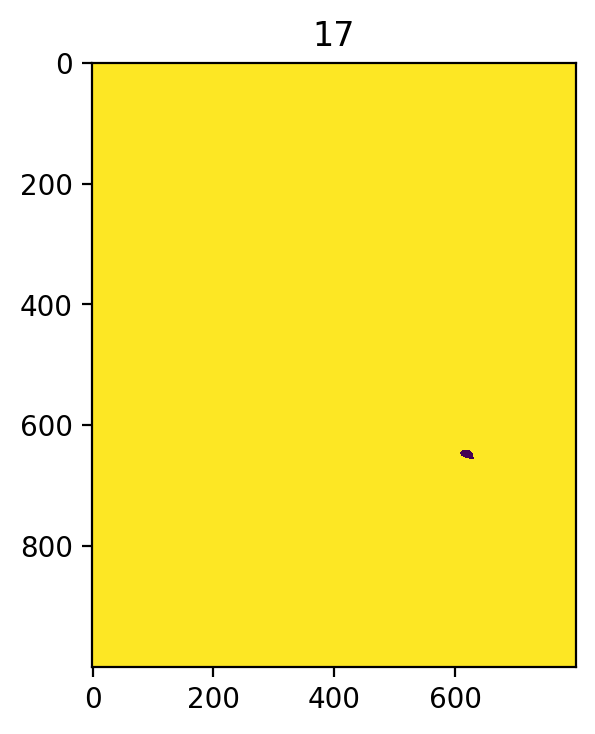

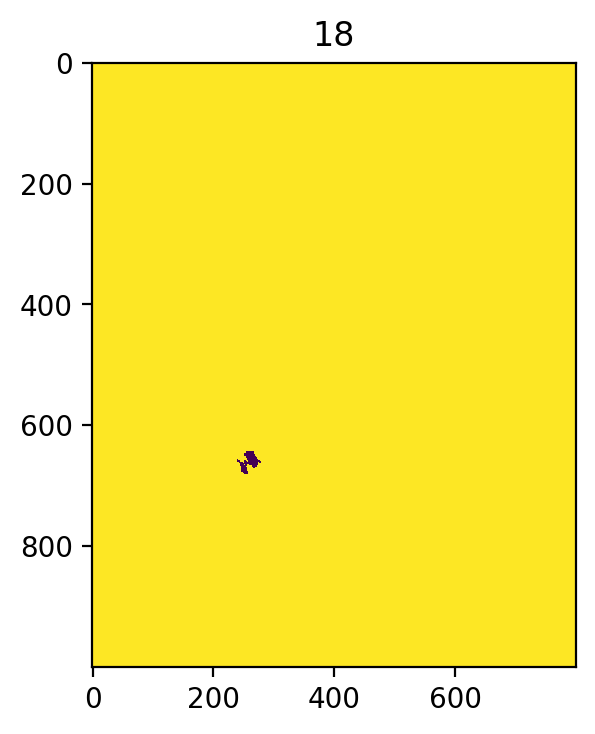

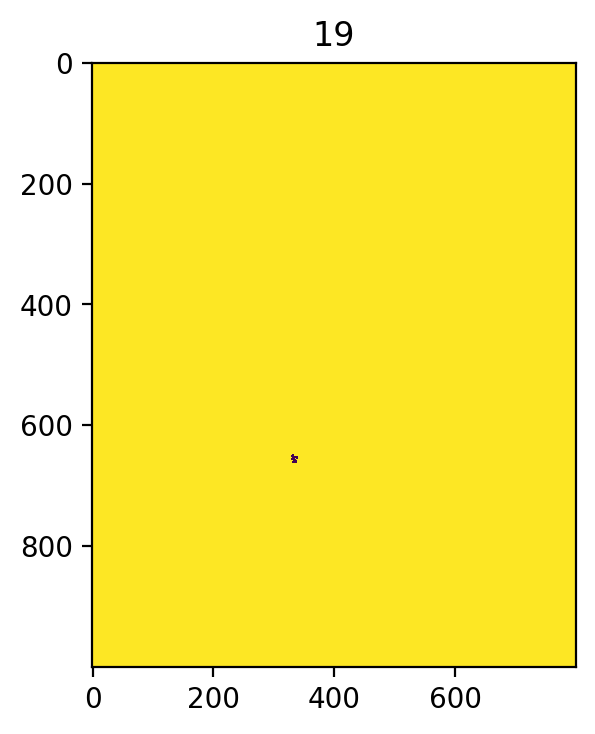

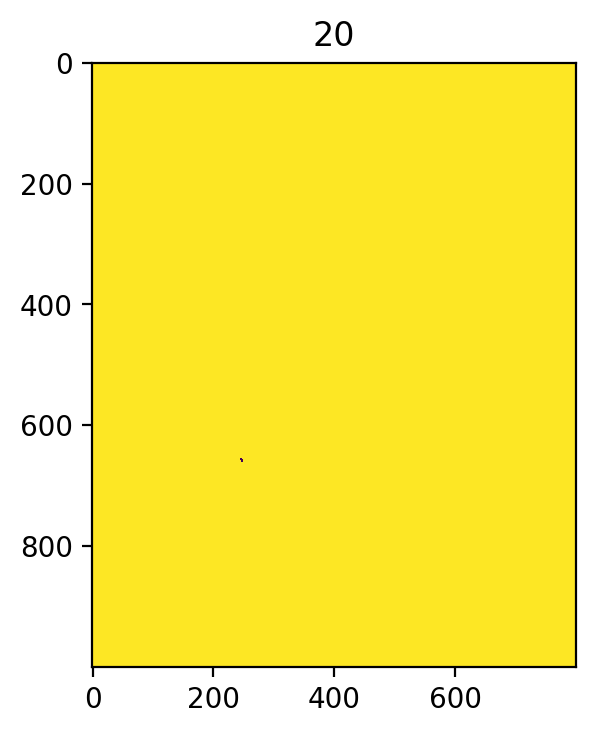

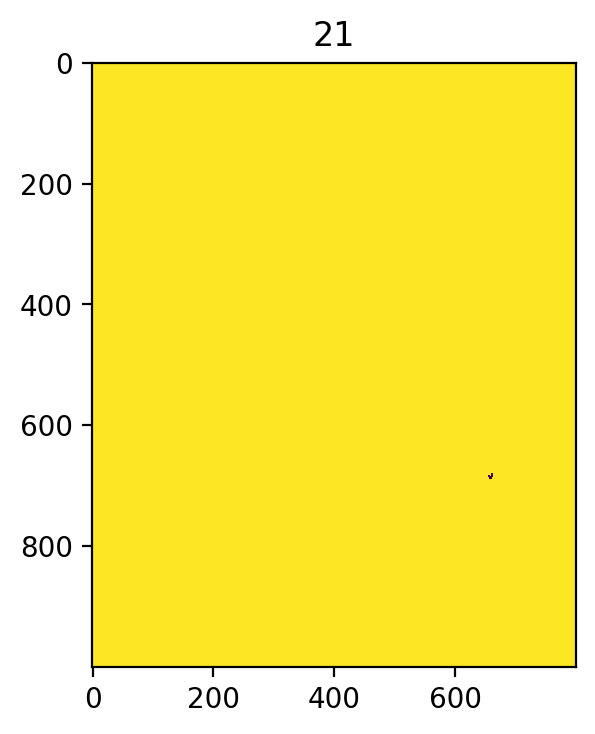

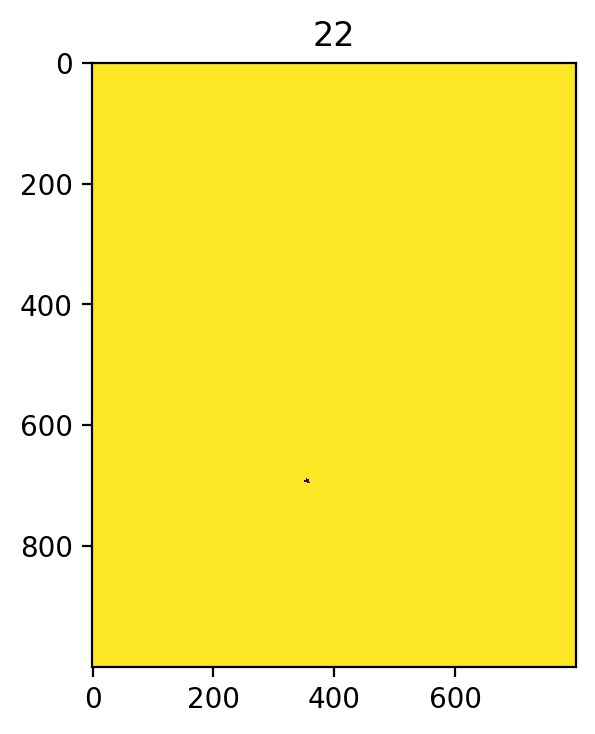

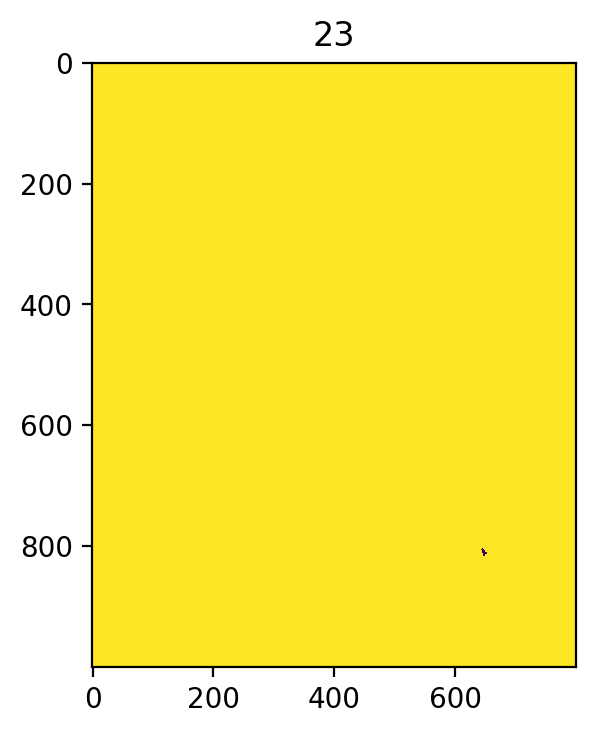

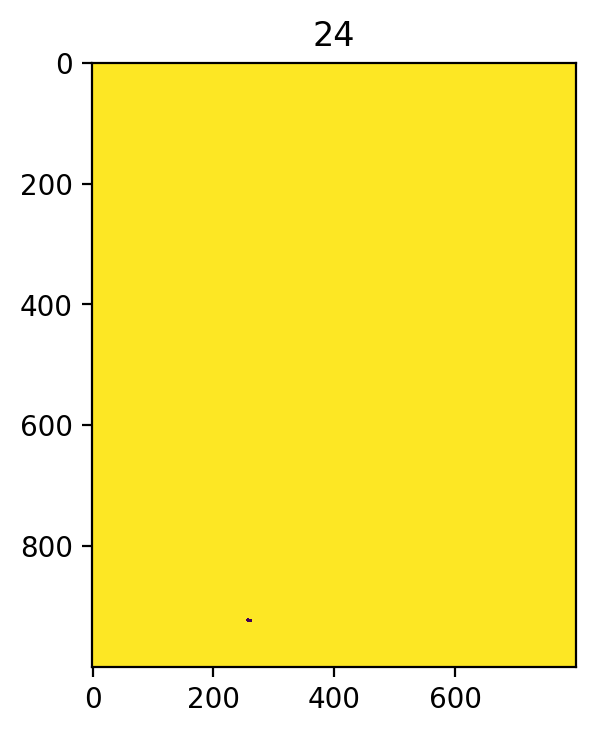

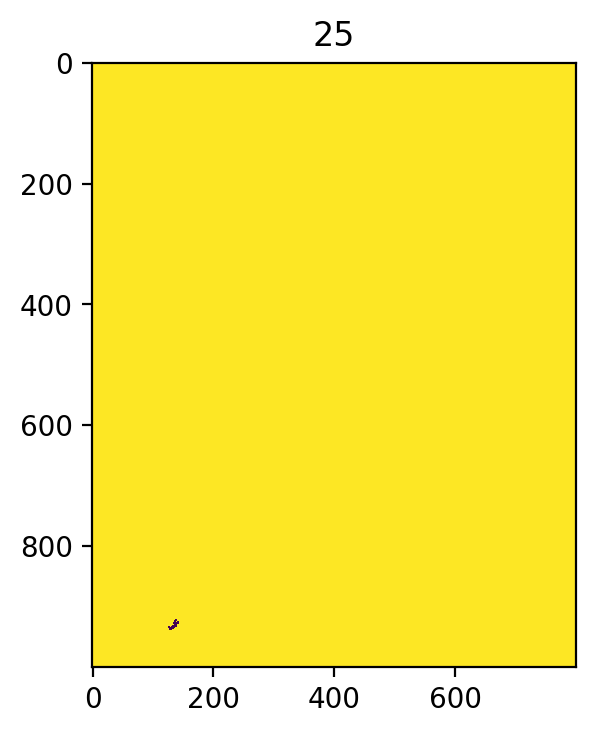

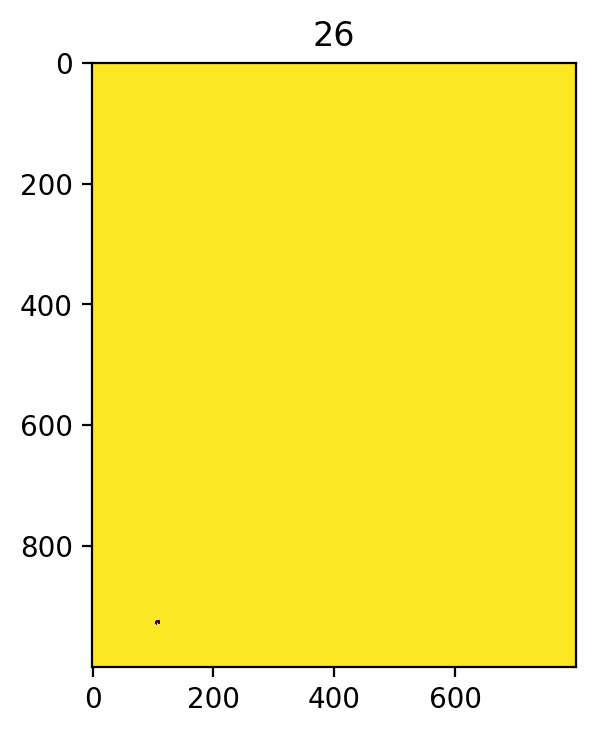

In [83]:
num_objects, labels = cv2.connectedComponents(tmp)
for i in range(num_objects):
    tmp = np.zeros(raw_pgm_35.shape,dtype=np.uint8) + 255
    tmp[labels==i] = 0
    fig3, ax3 = plt.subplots(figsize=(4, 4),dpi=200)
    plt.imshow(tmp[700:1700,700:1500])
    plt.title(i)
    plt.show()

In [84]:
def filter_labels(num_objects, labels):
    filter_labels_list = []
    trunk_label_dict = {}
    count = 0
    for i in range(num_objects):
        if len(labels[labels==i])<800:
            if (accu_map[labels==i,:][:,0] == 255).all():
                print("leaves")
            else:
                filter_labels_list.append(i)
                count+=1
                trunk_label_dict[count] = [ len(labels[labels==i]), ]
    return filter_labels_list, trunk_label_dict

In [92]:
accu_map.shape

(2048, 2048, 3)

In [85]:
filter_labels_list, trunk_label_dict = filter_labels(num_objects, labels)
len(filter_labels_list), filter_labels_list

leaves
leaves
leaves
leaves
leaves


20

In [88]:
def get_matched_circle(raw_pgm_binary, filter_labels_list):
    centroid_rawList = []
    circle_bd = np.zeros(raw_pgm_binary.shape, dtype=np.uint8)
    for i in filter_labels_list:
        A = []
        for x in range(raw_pgm_binary.shape[0]):
            for y in range(raw_pgm_binary.shape[1]):
                if labels[x][y] == i:
                    A.append(np.array([-x/(x*x+y*y), -y/(x*x+y*y), -1/(x*x+y*y)]))
        A = np.asarray(A)
        print('new one circle # of points: ', A.shape)
        
        k = np.linalg.inv(A.T @ A)
        k = k @ A.T
        k = k @ np.ones((k.shape[1],1))
        
        centre_x = k[0][0]/(-2)
        centre_y = k[1][0]/(-2)
        radius_r = np.sqrt(centre_x*centre_x+centre_y*centre_y-k[2][0])
        print('x,y,r: ', int(centre_x+0.5), int(centre_y+0.5), int(radius_r+0.5))
        
        centroid_rawList.append((int(centre_x+0.5),int(centre_y+0.5),int(radius_r+0.5)))

        cv2.circle(circle_bd,(int(centre_y), int(centre_x)), int(radius_r+0.5), 150, 2)
        # cv2.putText(circle_bd, #numpy array on which text is written
        #             str(int(centre_x))+','+str(int(centre_y))+','+str(int(radius_r)), #text
        #             (int(centre_y)-20,int(centre_x)-20), #position at which writing has to start
        #             cv2.FONT_HERSHEY_SIMPLEX, #font family
        #             0.6, #font size
        #             255, #font color
        #             1, cv2.LINE_AA) #font stroke
#         cv2.imshow('circle_bd',circle_bd)
#         cv2.waitKey(100)
    circle_bd[raw_pgm_binary==255]=255
    fig1,ax1 = plt.subplots(figsize=(8,8))
    plt.imshow(cv2.cvtColor(circle_bd, cv2.COLOR_BGR2RGB))
#     cv2.imwrite(file_path+'raw_circle_bd.png', circle_bd)

    return centroid_rawList

new one circle # of points:  (19, 3)
x,y,r:  779 1395 2
new one circle # of points:  (75, 3)
x,y,r:  783 1405 4
new one circle # of points:  (92, 3)
x,y,r:  791 1392 4
new one circle # of points:  (86, 3)
x,y,r:  796 1022 4
new one circle # of points:  (341, 3)
x,y,r:  934 1404 8
new one circle # of points:  (76, 3)
x,y,r:  1096 1406 4
new one circle # of points:  (168, 3)
x,y,r:  1287 842 6
new one circle # of points:  (135, 3)
x,y,r:  1317 1324 6
new one circle # of points:  (179, 3)
x,y,r:  1323 1183 7
new one circle # of points:  (505, 3)
x,y,r:  1347 1351 17
new one circle # of points:  (238, 3)
x,y,r:  1348 1320 7
new one circle # of points:  (673, 3)
x,y,r:  1360 958 13
new one circle # of points:  (125, 3)
x,y,r:  1355 1034 5
new one circle # of points:  (21, 3)
x,y,r:  1356 947 2
new one circle # of points:  (47, 3)
x,y,r:  1383 1359 3
new one circle # of points:  (55, 3)
x,y,r:  1392 1055 3
new one circle # of points:  (70, 3)
x,y,r:  1509 1347 4
new one circle # of points:  

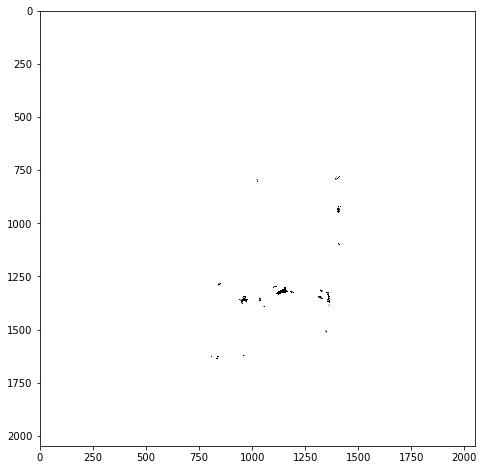

In [89]:
centroid_rawList = get_matched_circle(morph_pgm_binary_all, filter_labels_list)

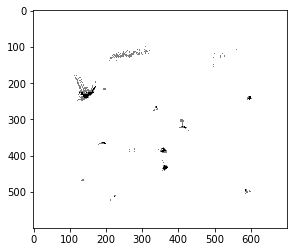

In [7]:
npColorMask = cv2.addWeighted(raw_pgm_binary_tmp1, 0.5, raw_pgm_binary_tmp, 0.5, 0.0)
plt.imshow(cv2.cvtColor(npColorMask[400:1000,1000:1700], cv2.COLOR_BGR2RGB))